# Time Series Simple - Explanation - Examples - Use cases

| Scenario | Recommended Model |
| -------- | ------------------ |
| Linear trend, seasonality |	SARIMA, Holt-Winters |
| Irregular patterns, external data |	XGBoost, LightGBM |
| Long-term dependencies |	LSTM, RNN |
| High-frequency data |	Fourier Transform + ARIMA |
| Multi-seasonality	| Prophet, STL + Residual Modeling |

## ARIMA. AutoRegressive Integrated Moving Average

ARIMA are a kind of black-box model.

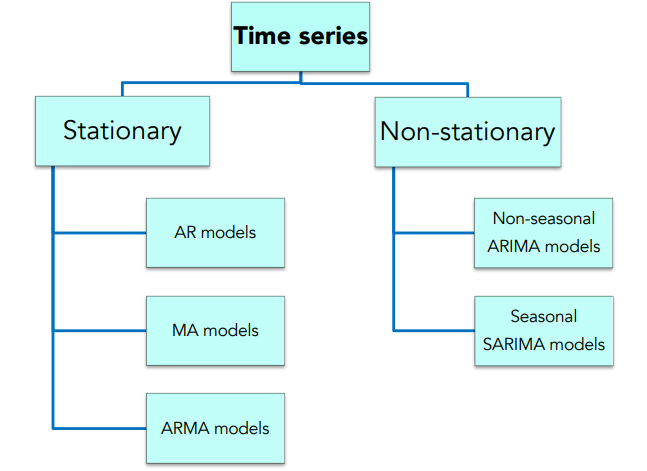

**Major Assumption** - The time series is stationary.

- no trend / no seasonality
- no systematic change in variation
- no periodic fluctuations

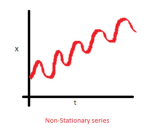
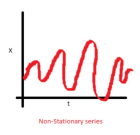
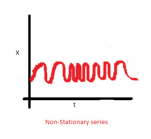

We can use detrending or differencing to make the time series stationary.

### ACF : autocorrelation function

measures the speed of variation of temporal evolutions

### PACF : partial autocorrelation function

The Partial Autocorrelation Function (PACF) isolates the direct correlation between the time series and its lagged values, excluding the influence of intermediate lags.


### White noise

At validation, the residuals should be white noise. that is, no correlations with past values and the best fit should be the mean -> zero.

### ARMA Intuition

A way to understand this model, it is to consider a stationary time serias as filtered white noise.

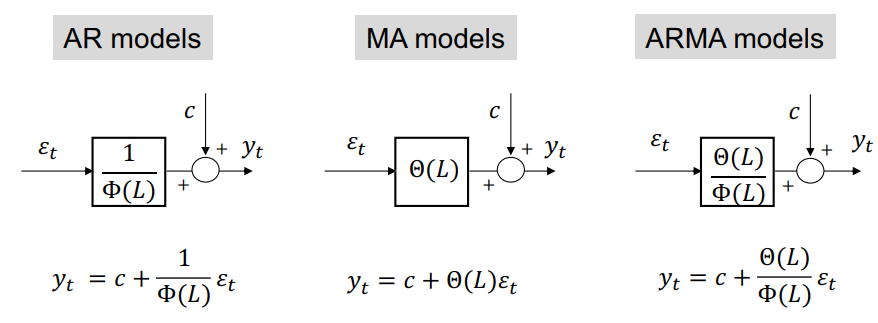

## AR (p) models : autoregressive 

- Stationarity conditions. 
- ACF tends to zero.
- **PACF** cuts off after p lags.

## MA (q) models : moving average

- Stationarity conditions.
- Invertibility conditions.
- **ACF** cuts off after q lags.
- PACF tends to zero.

## ARMA(p, q) models

- Stationarity conditions.
- Invertibility conditions.
- The ACF tends to 0 after q + 1 lags.
- PACF no special properties.
- NO SPECIAL RULES.



# Non - stationary time series

- has trend and seasonality 
- its ACF decreases slowly
- the ACF value at lag 1 is often large and positive

## Standard decomposition model

$$ y_t = T_t + S_t + x_t $$

T: trend
S: seasonality
X: stationary random component

- we can estimate the trend and seasonality and use it a a deterministic part of the model.
- Difference the time series 

### Differencing

Remove deterministic trends

- d=0: no differencing (no trend)
- d=1: first order differencing (remove trend)
- d=2: second order differencing (remove quadratic trend)

### Seasonal differencing

Applying lag-s differencing removes a seasonal pattern of perdiod s.

To remove deterministic seasonality. 

How to choose the order D of lag-s differencing?

- D=0: no differencing (no seasonality)
- D=1: first order differencing (remove seasonality)

Normally we use 12 for years

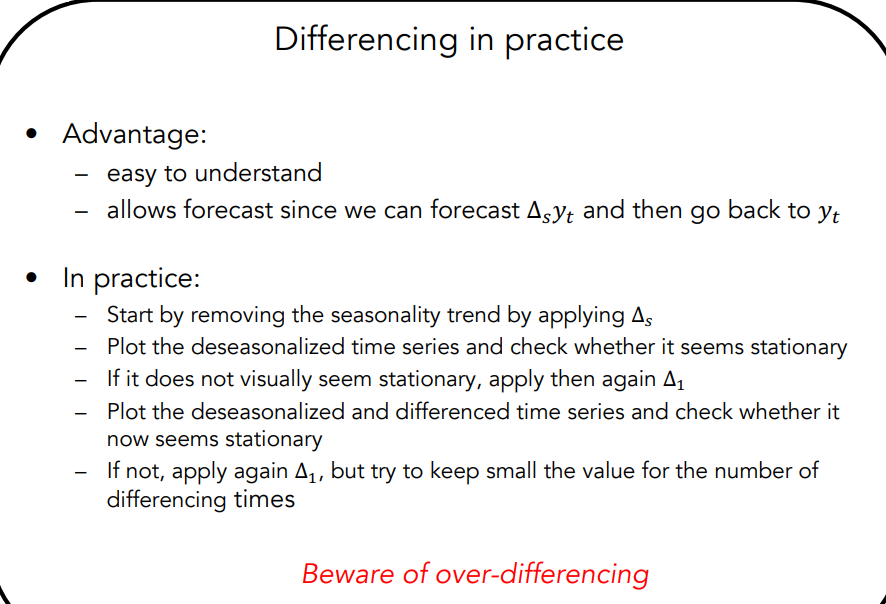

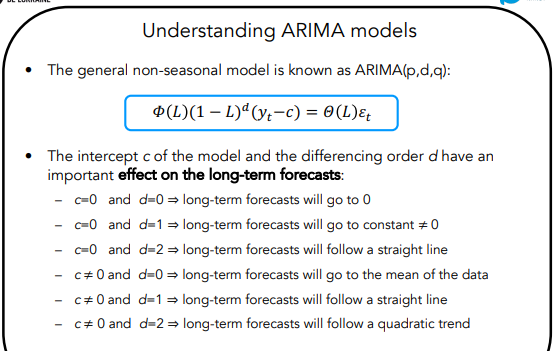
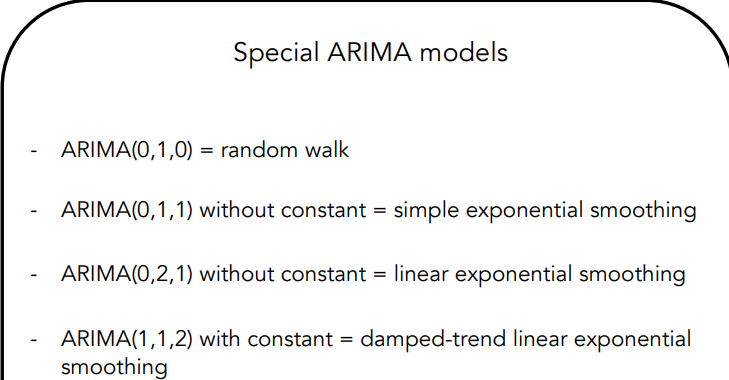

## How to choose orders (p, d, q) x (P, D, Q)s in a SARIMA model?

1. Use visual inspection to observe the trend and seasonality.
    1. Look at the ACF and PACF plots.
    
2. General tips
    1. Use differencing to take away the trend and seasonality.
    2. Keep orders simple.
        1. the maximum value for each of SARIMA terms p, d, q, P, D, Q is 2.
        2. In most cases, either p or q zero and $p + q \leq 3 $
        3. $d = \{0, 1, 2\}$, $p + q \leq 3 $
        4. $D = \{0, 1\}$, $P = \{ 0, 1\}$, $Q = \{ 0, 1\}$
        5. Standard value for $s$ is 12.

### Model selection

Information criteria. We consider $n_p$ as the number of parameters in the model. $N$ data points.

- AIC: Akaike Information Criterion

$ AIC = -2 \log(L) + 2 n_p $

- BIC: Bayesian Information Criterion

$ BIC = -2 \log(L) + \log(N) n_p $



## Predictions

### Confidence intervals

Assuming that the **residuals are normally distributed**, we can usefully assess the accuracy of a forecast by using $\sqrt{MSE}$ as an estimate of the error, where:

$$ MSE = \frac{1}{n} \sum_{t=1}^{n} (y_t - \hat{y}_t)^2 $$

An approximate prediction interval for the next observations is:

$$ \hat{y}_{t+1} \pm z_{\alpha/2} \sqrt{MSE} $$

where $z_{\alpha/2}$ is the $(1-\alpha/2)$ quantile of the standard normal distribution.

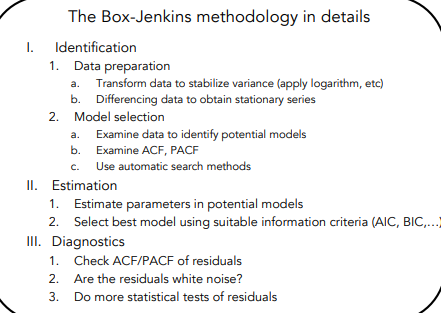
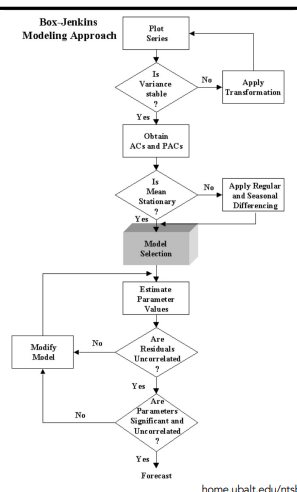

# Examples

In [2]:
%matplotlib inline

In [64]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm

from scipy.stats import shapiro

from sklearn.metrics import mean_squared_error


sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(6, 4))
sns.mpl.rc("font", size=12)

np.random.seed(42)

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def is_stationary_adf_test(series, display = False, significance_level = 0.05):
    result = adfuller(series)
    #if display:
    #    print('ADF Statistic: %f' % result[0], end='\t')
    #    print('p-value: %f' % result[1])
        
    if result[1] < significance_level:
        is_stationary = True
        if display:
            print("Augmented Dickey-Fuller: Series is Stationary")
    else:
        is_stationary = False
        if display:
            print("Augmented Dickey-Fuller: Series is Non-Stationary")
    return is_stationary


def is_stationary_kpss_test(series, display = False, significance_level = 0.05):
    result = kpss(series)
    #if display:
    #    print('KPSS Statistic: %f' % result[0], end='\t')
    #    print('p-value: %f' % result[1])
        
    if result[1] > significance_level:
        is_stationary = True
        if display:
            print("KPSS test: Series is Stationary")
    else:
        is_stationary = False
        if display:
            print("KPSS test: Series is NON-Stationary")
    return is_stationary

## Autoregressive model AR

In [6]:
arparams = np.array([0.5, 0.25])
#maparams = np.array([0.65, 0.35])

arparams = np.r_[1, -arparams]
maparams = np.r_[1]
nobs = 254

ar_t = ArmaProcess(arparams, maparams)
print("Is invertible: ", ar_t.isinvertible)
print("Is stationary: ", ar_t.isstationary)

Is invertible:  True
Is stationary:  True


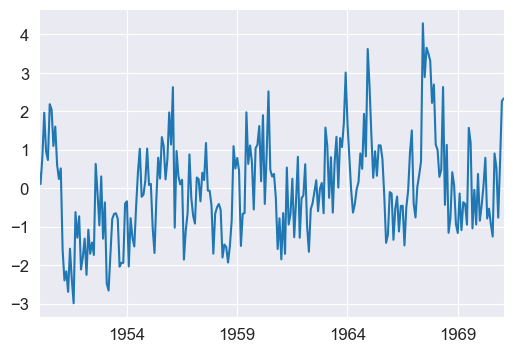

In [7]:
y = ar_t.generate_sample(nobs)
dates = pd.date_range('1950-1-1', periods=nobs, freq='ME')
y = pd.Series(y, index=dates)
y.plot()
plt.show()

#### Is the serie stationary?   

In [8]:
_ = is_stationary_adf_test(y, display=True)
_ = is_stationary_kpss_test(y, display=True)

Augmented Dickey-Fuller: Series is Stationary
KPSS test: Series is NON-Stationary


#### ACF and PACF

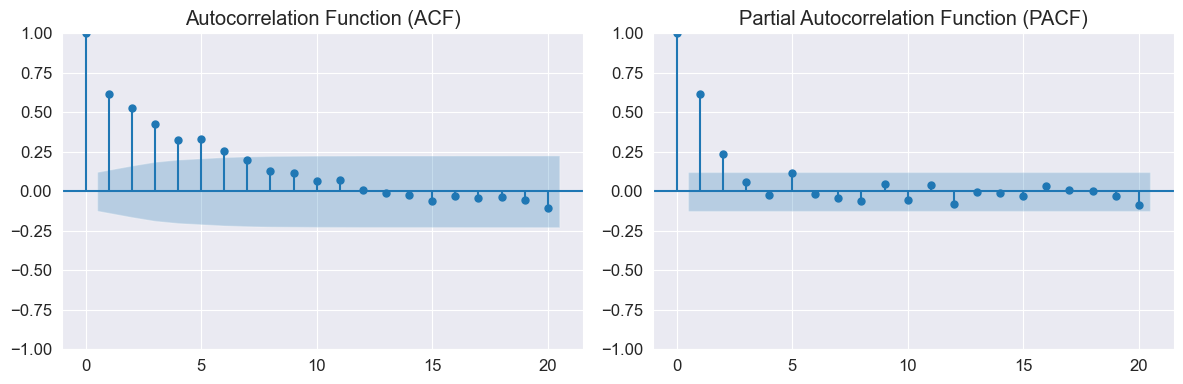

In [9]:
def plot_acf_pacf(series, lags=20, figsize=(12, 5)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")
    plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")
    plt.tight_layout()
    plt.show()

plot_acf_pacf(y, lags=20, figsize=(12, 4))

The PACF cuts off after 2 lag. This might indicate that the AR(2) model is a good fit.

In [10]:
model = AutoReg(y, lags = 1, trend='n') 
# trend='n' means no trend or constant. 
# default is 'c' for constant, 
# 'ct' for constant and trend and 't' for trend only
res = model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  254
Model:                     AutoReg(1)   Log Likelihood                -359.920
Method:               Conditional MLE   S.D. of innovations              1.004
Date:                Tue, 21 Jan 2025   AIC                            723.840
Time:                        14:47:08   BIC                            730.907
Sample:                    02-28-1950   HQIC                           726.683
                         - 02-28-1971                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.6252      0.050     12.613      0.000       0.528       0.722
                                    Roots                                    
                  Real          Imaginary           M

In [11]:
sel = ar_select_order(y, 10, trend='n', seasonal=False, ic='bic')
print(sel.ar_lags)
res = sel.model.fit()
print(res.summary())

[1, 2]
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  254
Model:                     AutoReg(2)   Log Likelihood                -351.319
Method:               Conditional MLE   S.D. of innovations              0.975
Date:                Tue, 21 Jan 2025   AIC                            708.638
Time:                        14:47:08   BIC                            719.226
Sample:                    03-31-1950   HQIC                           712.898
                         - 02-28-1971                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.4756      0.061      7.770      0.000       0.356       0.596
y.L2           0.2447      0.062      3.974      0.000       0.124       0.365
                                    Roots    

#### Residual diagnostic

We have to check if the residuals are white noise. 

- ACF and PACF of the residuals
- Ljung-Box test
- Normality test (QQ plot) or Shapiro-Wilk test or jarque-bera test
- Heteroskedasticity test

[]

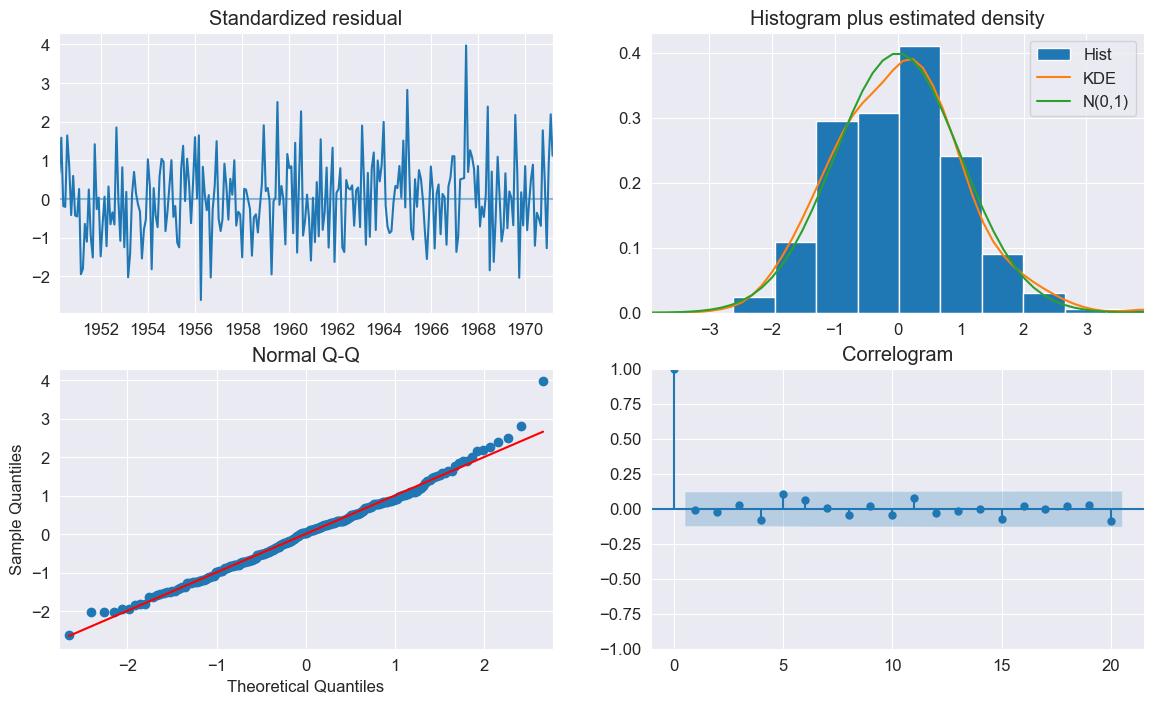

In [12]:
fig = res.plot_diagnostics(lags = 20, figsize=(14, 8))
plt.plot()

In [13]:
def test_normality(residuals, significance_level = 0.05):
    # Shapiro-Wilk Test
    # H0: The data is normally distributed
    _, p_shapiro = shapiro(residuals)
    if p_shapiro > significance_level:
        print("Shapiro-Wilk Test: Data is normally distributed")
    else:
        print("Shapiro-Wilk Test: Data is not normally distributed")
    
    # Jarque-Bera Test
    # H0: The data is normally distributed using skewness and kurtosis
    # It is sensible to use this test for large sample sizes and 
    # heavy tails in the data
    _, p_jarque_bera, _, _ = jarque_bera(residuals)
    if p_jarque_bera > significance_level:
        print("Jarque-Bera Test: Data is normally distributed")
    else:
        print("Jarque-Bera Test: Data is not normally distributed")
    
    # Ljung-Box Test
    # H0: No autocorrelatino
    df_ljung = acorr_ljungbox(residuals)
    ljung_p_values = df_ljung.iloc[:, 1]
    if np.all(ljung_p_values > significance_level):
        print("Ljung-Box Test: No autocorrelation")
    else:
        print("Ljung-Box Test: Autocorrelation")
        
    # ARCH Test
    # H0: Constant variance
    _, p_het_arch, _, _ = het_arch(residuals)
    if p_het_arch > significance_level:
        print("ARCH Test: Constant Variance")
    else:
        print("ARCH Test: Heteroscedasticity")
        
    # Stationarity Test
    # H0: The data is stationary
    is_stationary_adf_test(residuals, display=True)
    

In [14]:
test_normality(res.resid)

Shapiro-Wilk Test: Data is normally distributed
Jarque-Bera Test: Data is not normally distributed
Ljung-Box Test: No autocorrelation
ARCH Test: Constant Variance
Augmented Dickey-Fuller: Series is Stationary


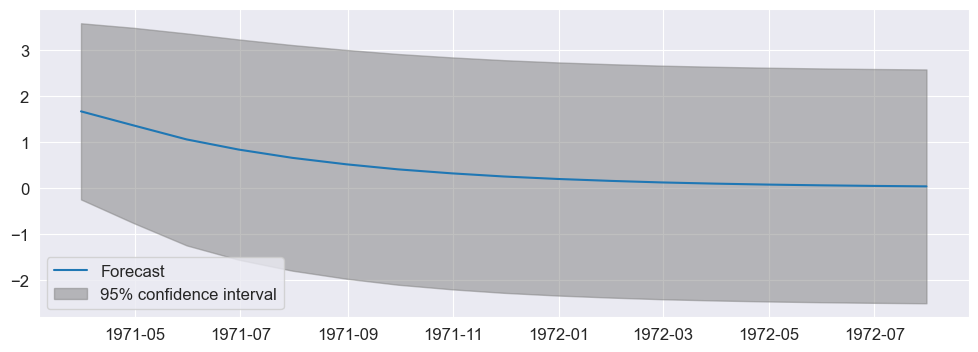

In [15]:
fig = res.plot_predict(start=len(y), end=270, dynamic=True, figsize=(12, 4))

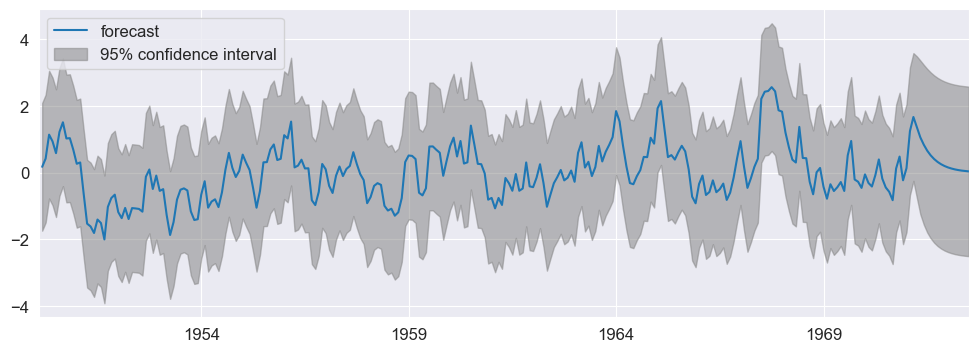

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
fig = plot_predict(res, start=1, end=270, dynamic=False, ax=ax)

#### Prediction

A good predictor can:

- Perform well on unseen that
- Generalize effectively (avoid overfitting)

Steps to evaluate **predictive** performance:

- Cross validation
    - Use time series cross-validation
    - Train data on earlier data adn evaluate its predictions on later data
    - Metrics: RMSE, MAE, MAPE, MASE
- Rolling window forecasting
    - Predict one steap ahead.
- Backtesting
    - Simulate predictions using the model on historical data, comparing forescasts with actual values.
    
    
    
While doing forecast, we use seach for the mean, that is

$$ E [ Y_{t+h} | Y_t, Y_{t-1}, \ldots ] $$

that is why it is deterministic.

In [17]:
def time_series_cv (data, max_lag, trend='c' , train_size = 0.7, test_size = 1):
    errors = []
    for i in range(train_size, len(data) - test_size):
        train, test = data[:i], data[i:i+test_size]
        
        # Fit AR model on train data
        model = AutoReg(train, lags=max_lag, trend=trend)
        res = model.fit()
        
        # Predict test data
        pred = res.predict(start=i, end=i+test_size-1)
        
        # Compute error
        errors.append(mean_squared_error(test, pred))
    return np.mean(errors)

In [18]:
def backtesting(data, max_lag, trend='c', train_size=0.7):
    """
    Backtesting: Train once on the initial portion of the data, and test on the remainder.
    """
    # Define train-test split
    split_index = int(len(data) * train_size)
    train = data[:split_index]
    test = data[split_index:]

    # Fit model on training data
    model = AutoReg(train, lags=max_lag, trend=trend)
    fit = model.fit()

    # Forecast test set
    forecast = fit.predict(start=len(train), end=len(train)+len(test)-1)

    # Calculate metrics
    mse = mean_squared_error(test, forecast)
    print(f"Backtesting MSE: {mse}")
    
    mape = mean_absolute_percentage_error(test, forecast)
    print(f"Backtesting MAPE: {mape:.2f}%")

    # Return predictions and actual values
    return forecast, test


In [19]:
test_size = 1 # 1 year
train_size = int(len(y) * 0.7) # 70% of data
max_lag = 2
trend = 'c'
print(time_series_cv(y, max_lag, trend, train_size, test_size))

1.1741281736675706


In [20]:
# Run backtesting
forecast, actuals = backtesting(y, max_lag=2, trend='c', train_size=0.7)

Backtesting MSE: 2.196317789650442
Backtesting MAPE: 112.07%


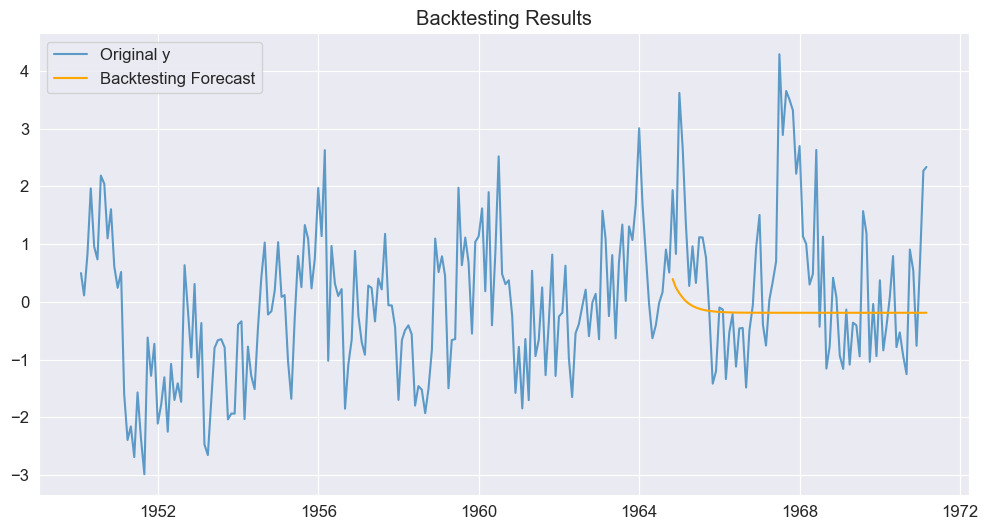

In [21]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y, label="Original y", alpha=0.7)
plt.plot(forecast, label="Backtesting Forecast", color="orange")
plt.legend()
plt.title("Backtesting Results")
plt.show()

In [22]:
def time_series_cv_plot(data, max_lag, trend='c', train_size=45, test_size=1):
    """
    Perform rolling time series cross-validation and plot predictions vs actuals for 1-step-ahead forecasts.
    """
    predictions = []
    actuals = []
    
    # Rolling window cross-validation
    for i in range(train_size, len(data) - test_size + 1):
        train, test = data[:i], data[i:i+test_size]

        # Fit AR model
        model = AutoReg(train, lags=max_lag, trend=trend)
        res = model.fit()

        # Predict next step(s)
        forecast = res.predict(start=i, end=i+test_size-1)

        # Store predictions and actuals
        predictions.extend(forecast)
        actuals.extend(test)

    # Convert to Pandas Series for alignment
    predictions_series = pd.Series(predictions, index=data.index[train_size:len(data) - test_size + 1])
    actuals_series = pd.Series(actuals, index=data.index[train_size:len(data) - test_size + 1])

    # Plot predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Original Data", alpha=0.7)
    plt.plot(predictions_series, label="Predicted (1-Step Ahead)", color="orange")
    #plt.scatter(actuals_series.index, actuals_series, label="Actuals", color="red", alpha=0.6)
    plt.title("Time Series Cross-Validation: 1-Step Ahead Predictions")
    plt.legend()
    plt.show()

    # Calculate error
    mse = mean_squared_error(actuals, predictions)
    print(f"Mean Squared Error (1-Step Ahead): {mse}")
    
    mape = mean_absolute_percentage_error(actuals, predictions)
    print(f"Mean Absolute Percentage Error (1-Step Ahead): {mape:.2f}%")

    return predictions_series, actuals_series

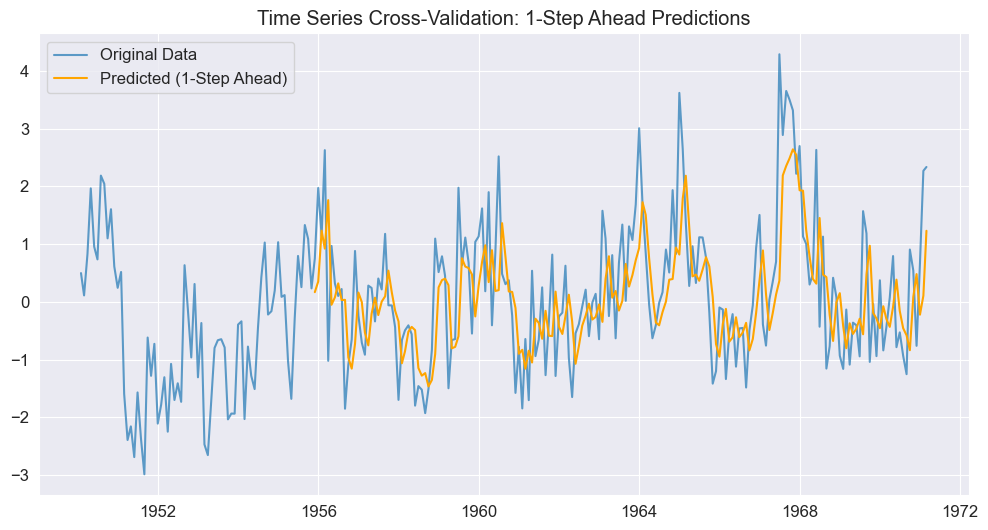

Mean Squared Error (1-Step Ahead): 1.0271175468039997
Mean Absolute Percentage Error (1-Step Ahead): 185.87%


In [23]:
predictions, actuals = time_series_cv_plot(y, max_lag=2, trend='c', train_size=70, test_size=1)

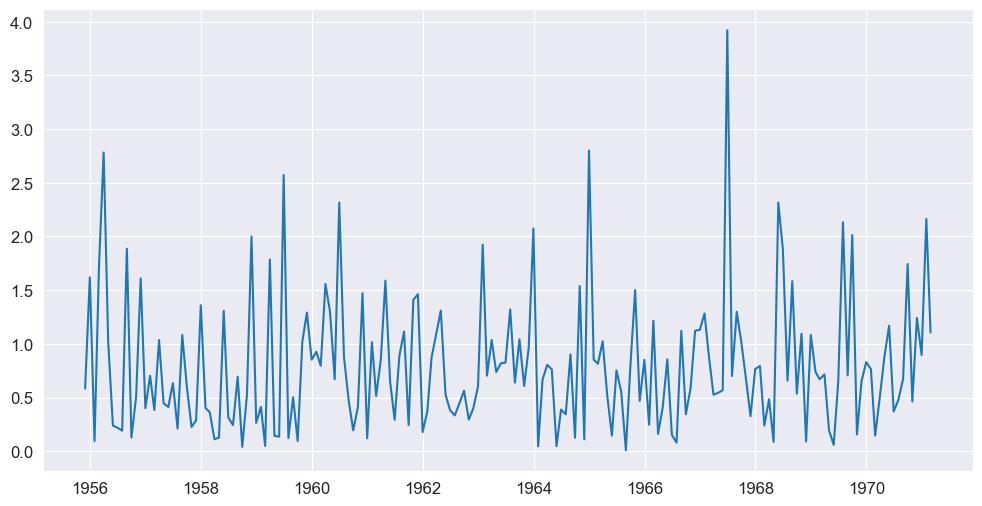

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(np.abs(actuals- predictions))

## Fit vs Prediction performance: How to choose the best model?

- Fit-Oriented Approach:
    - Focus on statistical tests (AIC, residual diagnostics).
    - Suitable when the goal is understanding historical patterns.
- Prediction-Oriented Approach:
    - Use cross-validation and backtesting to evaluate forecasting accuracy.
    - Suitable when the goal is reliable forecasts for future values.

# Moving average

In [25]:
#arparams = np.array([0.5, -0.25])
maparams = np.array([0.65, 0.35])

arparams = np.r_[1]
maparams = np.r_[1, maparams]
nobs = 254

ar_t = ArmaProcess(arparams, maparams)
print("Is invertible: ", ar_t.isinvertible)
print("Is stationary: ", ar_t.isstationary)

Is invertible:  True
Is stationary:  True


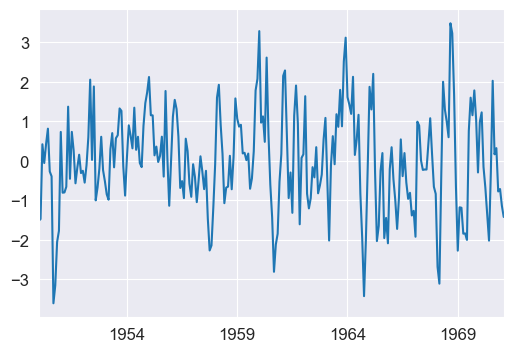

In [26]:
y = ar_t.generate_sample(nobs)
dates = pd.date_range('1950-1-1', periods=nobs, freq='ME')
y = pd.Series(y, index=dates)
y.plot()
plt.show()

In [27]:
_ = is_stationary_adf_test(y, display=True)
_ = is_stationary_kpss_test(y, display=True)

Augmented Dickey-Fuller: Series is Stationary
KPSS test: Series is Stationary


C:\Users\Marti\AppData\Local\Temp\ipykernel_8508\1064370172.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)


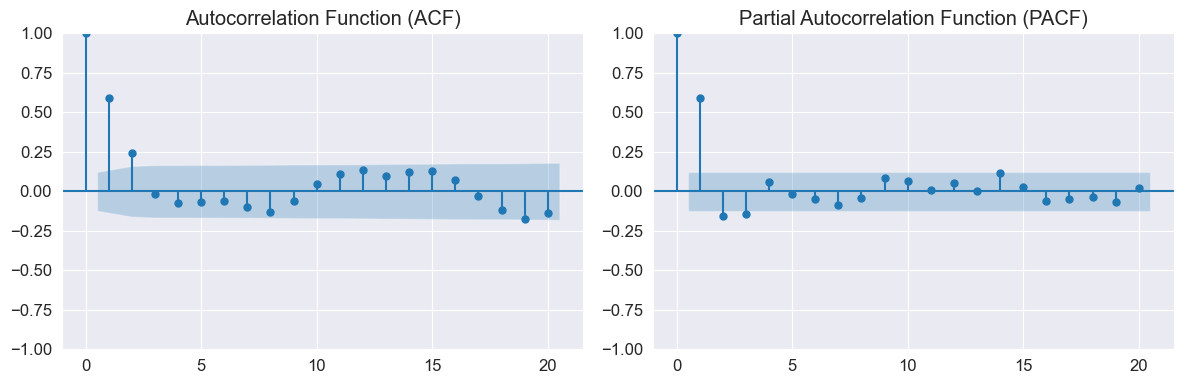

In [28]:
def plot_acf_pacf(series, lags=20, figsize=(12, 5)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")
    plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")
    plt.tight_layout()
    plt.show()

plot_acf_pacf(y, lags=20, figsize=(12, 4))

In [29]:
result_ma = arma_order_select_ic(y, ic='aic', trend='n', max_ar=0, max_ma=6)
best_order_ma = result_ma['aic_min_order']
print("Best order (MA):", best_order_ma)

model_ma = ARIMA(y, trend='n', order=(0, 0, best_order_ma[-1]))
model_ma_fit = model_ma.fit()
print(model_ma_fit.summary())

Best order (MA): (0, 2)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  254
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -357.320
Date:                Tue, 21 Jan 2025   AIC                            720.640
Time:                        14:47:13   BIC                            731.252
Sample:                    01-31-1950   HQIC                           724.909
                         - 02-28-1971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6538      0.057     11.426      0.000       0.542       0.766
ma.L2          0.3541      0.064      5.560      0.000       0.229       0.479
sigma2         0.9739      0

In [30]:
result_ar = arma_order_select_ic(y, ic='aic', trend='n', max_ar=6, max_ma=0)
best_order_ar = result_ar['aic_min_order']
print("Best order (AR):", best_order_ar)

model_ar = ARIMA(y, trend='n', order=(best_order_ar[-1], 0, 0))
model_ar_fit = model_ar.fit()
print(model_ar_fit.summary())

Best order (AR): (3, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  254
Model:                          ARIMA   Log Likelihood                -417.749
Date:                Tue, 21 Jan 2025   AIC                            837.498
Time:                        14:47:13   BIC                            841.035
Sample:                    01-31-1950   HQIC                           838.921
                         - 02-28-1971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.5706      0.135     11.611      0.000       1.306       1.836
Ljung-Box (L1) (Q):                  89.60   Jarque-Bera (JB):                 0.21
Prob(Q):               

The best in this case is the Moving Average model.

[]

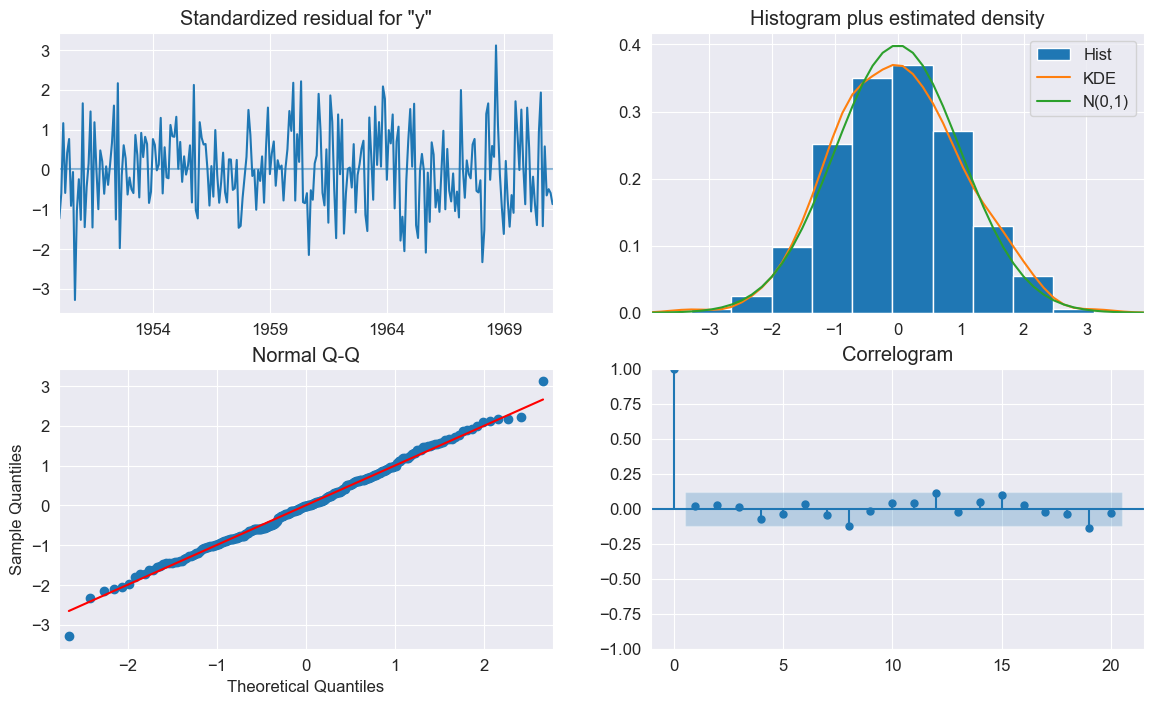

In [31]:
fig = model_ma_fit.plot_diagnostics(lags = 20, figsize=(14, 8))
plt.plot()

In [32]:
test_normality(model_ma_fit.resid)

Shapiro-Wilk Test: Data is normally distributed
Jarque-Bera Test: Data is normally distributed
Ljung-Box Test: No autocorrelation
ARCH Test: Constant Variance
Augmented Dickey-Fuller: Series is Stationary


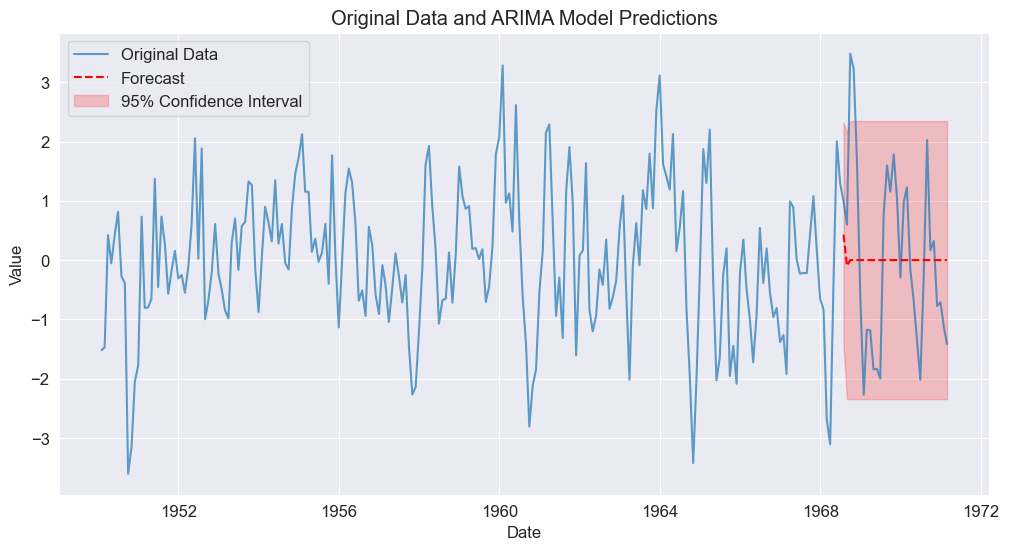

In [33]:
# Define ARIMA model and predict last 2 years with confidence intervals
def predict_last_m_values_with_confidence(y, model_order, m_values=24):
    """
    Predict the last m_values (e.g., 2 years) of a time series using ARIMA and display the confidence interval.

    Parameters:
    - y: pd.Series, the original time series
    - model_order: tuple, ARIMA(p, d, q) order
    - m_values: int, number of time steps to predict

    Returns:
    - None (plots the results)
    """
    # Fit the ARIMA model
    train_y = y[:-m_values]
    
    model = ARIMA(train_y, order=model_order)
    model_fit = model.fit()

    # Forecast last m_values
    start = len(train_y)
    end = start + m_values - 1
    forecast_object = model_fit.get_forecast(steps=m_values)
    forecast = forecast_object.predicted_mean
    conf_int = forecast_object.conf_int(alpha=0.05)
    
    # Create new index for predictions
    prediction_index = pd.date_range(start=train_y.index[-1] + pd.offsets.MonthEnd(1), periods=m_values, freq='ME')

    # Plot original data and forecast with confidence intervals
    plt.figure(figsize=(12, 6))
    plt.plot(y, label='Original Data', alpha=0.7)
    plt.plot(prediction_index, forecast, color='red', linestyle='--', label='Forecast')
    plt.fill_between(prediction_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2, label='95% Confidence Interval')
    plt.title("Original Data and ARIMA Model Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


predict_last_m_values_with_confidence(y, model_order=(0, 0, 2), m_values=32)


In [34]:
test_size = 12 # 1 year
train_size = int(len(y) * 0.7) # 70% of data
max_lag = 2
trend = 'n'
print(time_series_cv(y, max_lag, trend, train_size, test_size))

1.8879443654937873


In [35]:
_, _ = backtesting(y, max_lag=2, trend='n', train_size=0.7)

Backtesting MSE: 1.9449679419645465
Backtesting MAPE: 99.00%


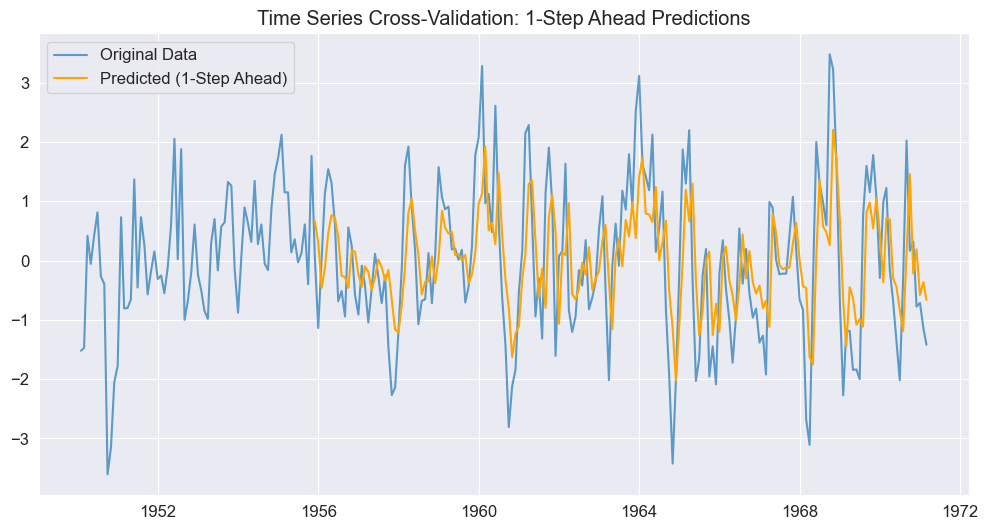

Mean Squared Error (1-Step Ahead): 1.0698926878742043
Mean Absolute Percentage Error (1-Step Ahead): 173.10%


In [36]:
_, _ = time_series_cv_plot(y, max_lag=2, trend='n', train_size=70, test_size=1)

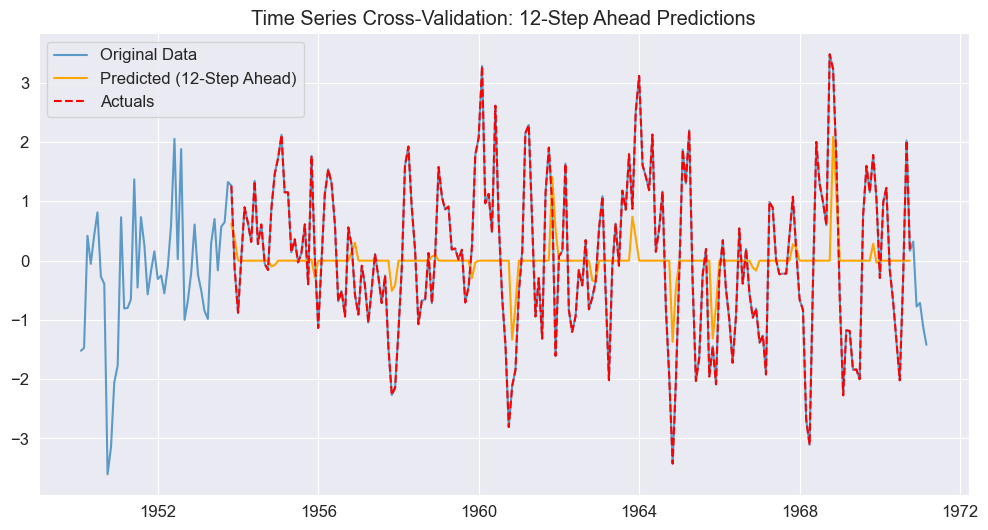

Mean Squared Error (12-Step Ahead): 1.466104956013265
Mean Absolute Percentage Error (12-Step Ahead): 99.02%


In [37]:
def time_series_cv_plot_forecast(data, pqd = (1, 0, 1), trend='c', train_size=45, forecast_steps=24):
    """
    Perform rolling time series cross-validation for multi-step forecasts (e.g., 2-3 years) and plot predictions vs actuals.
    The rolling window ensures no overlapping values between predictions.
    """
    predictions = []
    actuals = []
    
    # Rolling window cross-validation
    for i in range(train_size, len(data) - forecast_steps + 1, forecast_steps):
        train, test = data[:i], data[i:i+forecast_steps]

        # Fit AR model
        model = ARIMA(train, order=pqd, trend=trend)
        res = model.fit()

        # Predict next forecast_steps
        forecast = res.predict(start=i, end=i+forecast_steps-1)

        # Store predictions and actuals
        predictions.extend(forecast)
        actuals.extend(test)

    # Convert to Pandas Series for alignment
    prediction_index = pd.date_range(start=data.index[train_size], periods=len(predictions), freq=data.index.freq)
    predictions_series = pd.Series(predictions, index=prediction_index)
    actuals_index = pd.date_range(start=data.index[train_size], periods=len(actuals), freq=data.index.freq)
    actuals_series = pd.Series(actuals, index=actuals_index)

    # Plot predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Original Data", alpha=0.7)
    plt.plot(predictions_series, label=f"Predicted ({forecast_steps}-Step Ahead)", color="orange")
    plt.plot(actuals_series, label="Actuals", color="red", linestyle="--")
    plt.title(f"Time Series Cross-Validation: {forecast_steps}-Step Ahead Predictions")
    plt.legend()
    plt.show()

    # Calculate error
    mse = mean_squared_error(actuals, predictions)
    print(f"Mean Squared Error ({forecast_steps}-Step Ahead): {mse}")
    
    mape = mean_absolute_percentage_error(actuals, predictions)
    print(f"Mean Absolute Percentage Error ({forecast_steps}-Step Ahead): {mape:.2f}%")

    return predictions_series, actuals_series

# Example Usage:
# Assuming `data` is a Pandas Series with a proper datetime index
# Predict 24-36 months (2-3 years) ahead using a rolling window
predictions, actuals = time_series_cv_plot_forecast(y, pqd=(0,0,2), trend='n', train_size=45, forecast_steps=12)

C:\Users\Marti\AppData\Local\Temp\ipykernel_8508\774717856.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  simulations_df.index = pd.date_range(start=y.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')


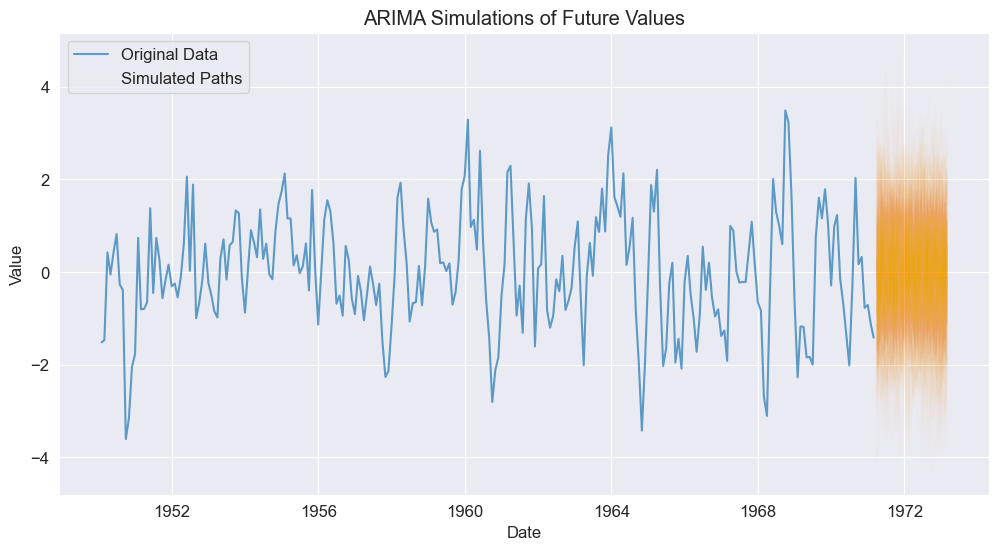

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(y, order=(0, 0, 2))  # Replace with your data and order
model_fit = model.fit()

# Simulate future values
n_simulations = 500  # Number of simulated paths
forecast_steps = 24  # Future steps to forecast
simulations = []

for _ in range(n_simulations):
    simulated = model_fit.simulate(nsimulations=forecast_steps)
    simulations.append(simulated)

# Convert to DataFrame for plotting
simulations_df = pd.DataFrame(simulations).T
simulations_df.index = pd.date_range(start=y.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')

# Plot original data and simulations
plt.figure(figsize=(12, 6))
plt.plot(y, label="Original Data", alpha=0.7)
for i in range(n_simulations):
    plt.plot(simulations_df.index, simulations_df.iloc[:, i], color="orange", alpha=0.01)
plt.title("ARIMA Simulations of Future Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(["Original Data", "Simulated Paths"])
plt.show()


Mean Squared Error: 4.1440022697657435


Text(0.5, 0, 'Date')

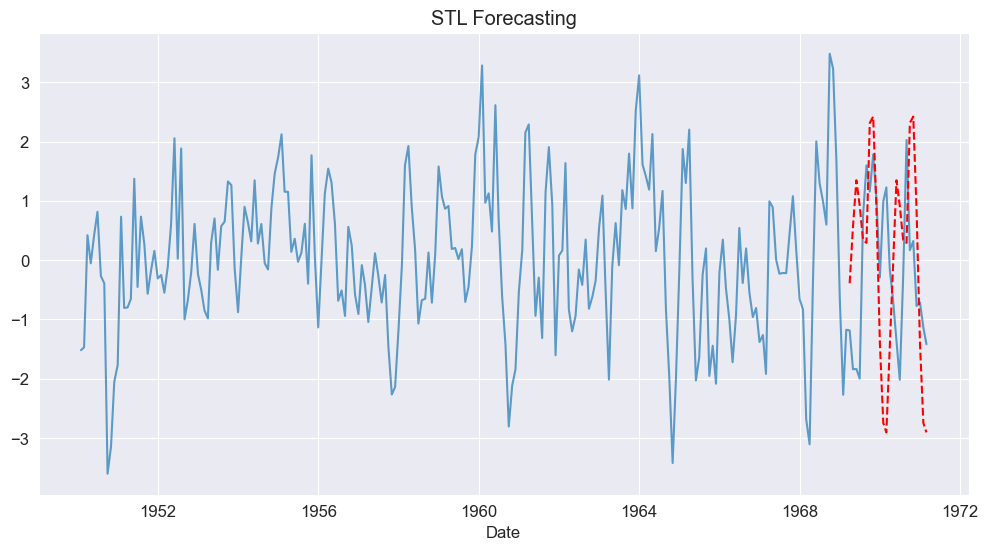

In [39]:
from statsmodels.tsa.forecasting.stl import STLForecast

forecast_steps = 24
train = y[:-forecast_steps]

stlf = STLForecast(train, ARIMA, period=12, model_kwargs={"order": (0, 0, 2)})
stfl_fit = stlf.fit()
forecast = stfl_fit.forecast(steps=forecast_steps)

mse = mean_squared_error(y[-forecast_steps:], forecast)
print(f"Mean Squared Error: {mse}")


plt.figure(figsize=(12, 6))
plt.plot(y, label="Original Data", alpha=0.7)
plt.plot(forecast, label="STL Forecast", color="red", linestyle="--")
plt.title("STL Forecasting")
plt.xlabel("Date")

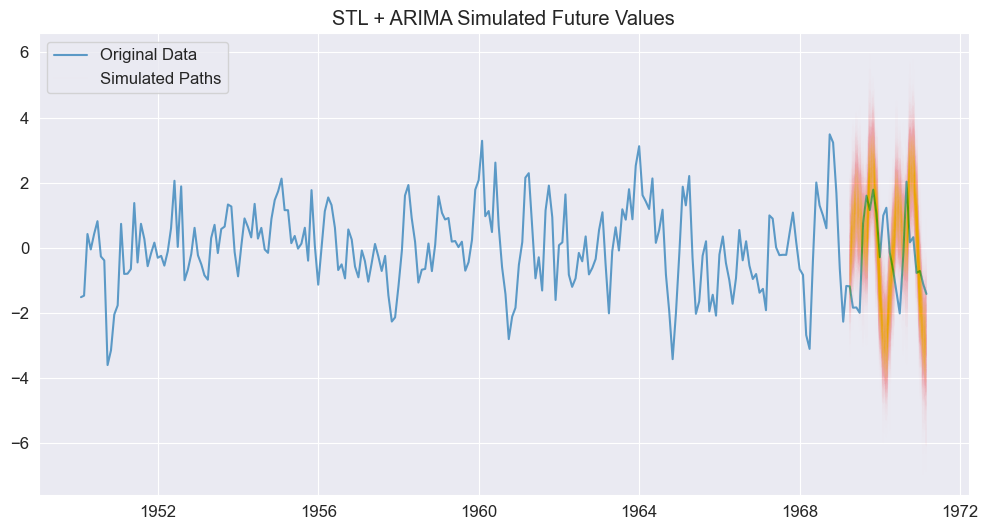

In [40]:
from statsmodels.tsa.forecasting.stl import STLForecast

stlf = STLForecast(train, ARIMA, model_kwargs={"order": (0, 0, 2)})
stlf_fit = stlf.fit()

# Forecast deterministic mean
forecast = stlf_fit.forecast(steps=forecast_steps)

# Extract fitted values from the model result
fitted_values = stlf_fit.model_result.fittedvalues

# Calculate residuals
residuals = train - fitted_values

# Compute standard deviation of residuals
residual_std = residuals.std()
simulated_paths = []
for _ in range(500):
    simulated = forecast + np.random.normal(0, residual_std, size=len(forecast))
    simulated_paths.append(simulated)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y, label="Original Data", alpha=0.7)
for sim in simulated_paths:
    plt.plot(pd.date_range(start=train.index[-1] + pd.offsets.MonthEnd(1), periods=24, freq='ME'), sim, color="orange", alpha=0.005)
plt.title("STL + ARIMA Simulated Future Values")
plt.legend(["Original Data", "Simulated Paths"])
plt.show()


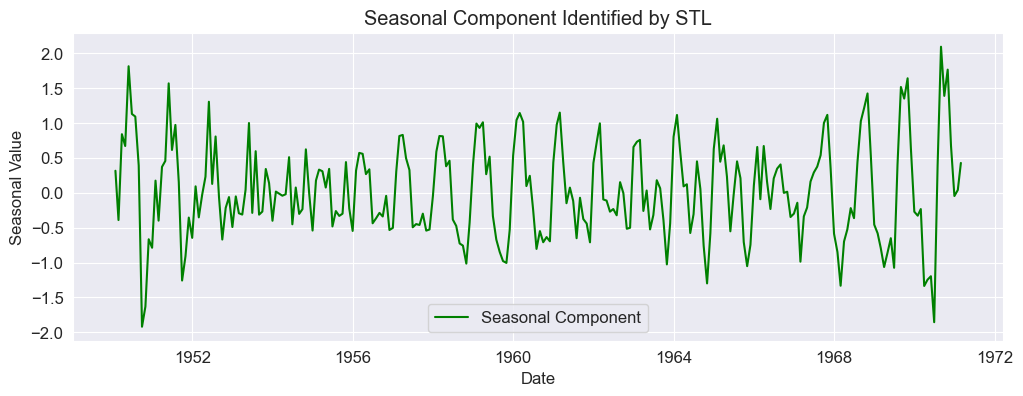

In [41]:
def check_stl_seasonality(y, period):
    """
    Decompose the time series using STL and display the seasonal component.

    Parameters:
    - y: pd.Series, the original time series
    - period: int, seasonal period (e.g., 12 for monthly data)

    Returns:
    - None (plots the seasonal component)
    """
    stl = STL(y, period=period)
    result = stl.fit()

    # Plot seasonal component
    plt.figure(figsize=(12, 4))
    plt.plot(result.seasonal, label="Seasonal Component", color="green")
    plt.title("Seasonal Component Identified by STL")
    plt.xlabel("Date")
    plt.ylabel("Seasonal Value")
    plt.legend()
    plt.show()

    return result.seasonal

seasonal_component = check_stl_seasonality(y, period=12)

### Lets do stochastic simulation.

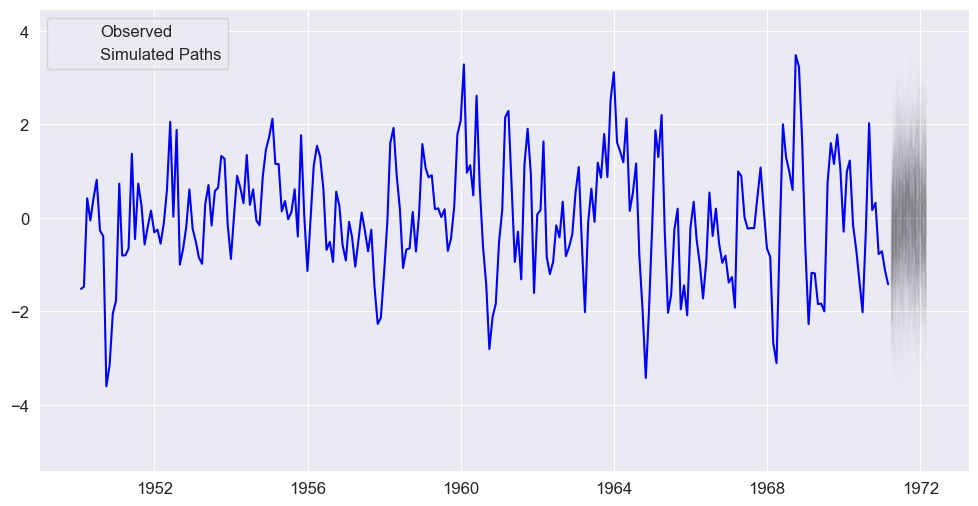

In [42]:
model = ARIMA(y, order=(0, 0, 2))  # Replace with your data and order
model_fit = model.fit()

# Stochastic forecast
n_simulations = 500
steps = 12
simulated_paths = []

for _ in range(n_simulations):
    history = list(y)
    residuals = list(model_fit.resid)
    simulated_path = []
    
    for step in range(steps):
        # Generate random error
        epsilon = np.random.normal(0, model_fit.resid.std())
        
        # ARIMA formula with stochastic error
        #ar_term = sum(model_fit.arparams * np.array(history[-len(model_fit.arparams):][::-1]))
        ma_term = sum(model_fit.maparams * np.array(residuals[-len(model_fit.maparams):][::-1]))
        next_value = ma_term + epsilon #+ ar_term
        
        # Update history and residuals
        history.append(next_value)
        residuals.append(epsilon)
        simulated_path.append(next_value)
    
    simulated_paths.append(simulated_path)


plt.figure(figsize=(12, 6))
for path in simulated_paths:
    dates = pd.date_range(start=y.index[-1] + pd.offsets.MonthEnd(1), periods=steps, freq='ME')
    plt.plot(dates, path, color="gray", alpha=0.005)

plt.plot(y, label="Observed", color="blue")
plt.legend(["Observed", "Simulated Paths"])
plt.show()


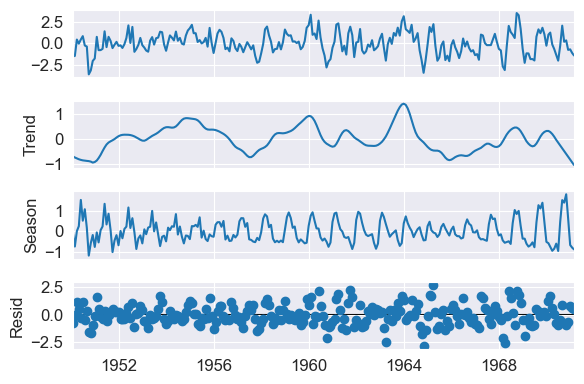

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Assuming 'y' is your time series data as a Pandas Series
stl = STL(y, seasonal=13)  # 'seasonal' parameter depends on your data's periodicity
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot components
result.plot()
plt.show()

## Working with another data set as training

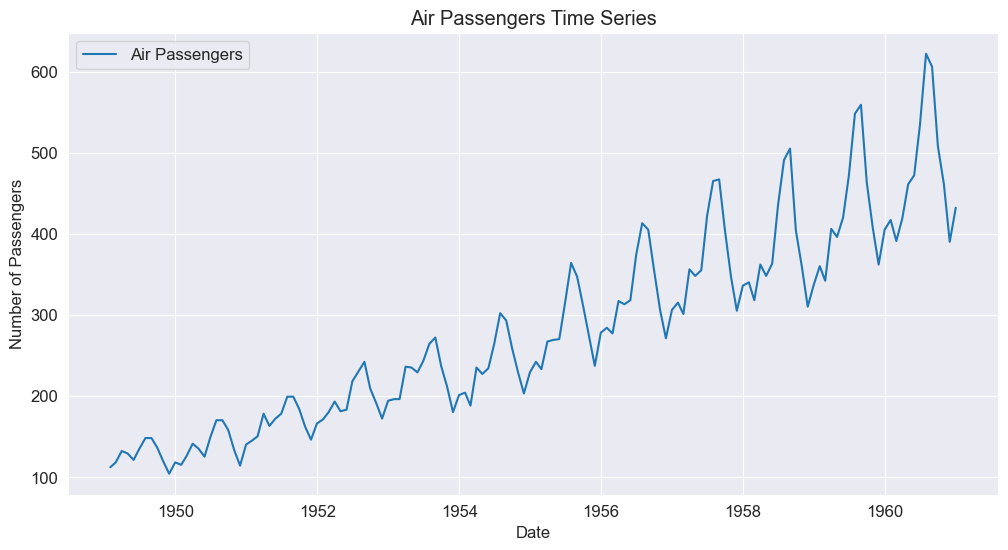

In [44]:
from statsmodels.datasets import get_rdataset

dataset = get_rdataset("AirPassengers", package="datasets")
air_passengers = dataset.data 

air_passengers.index = pd.date_range(start='1949-01-01', periods=len(air_passengers), freq='ME')
air_passengers_series_normal = air_passengers['value']

plt.figure(figsize=(12, 6))
plt.plot(air_passengers_series_normal, label="Air Passengers")
plt.title("Air Passengers Time Series")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

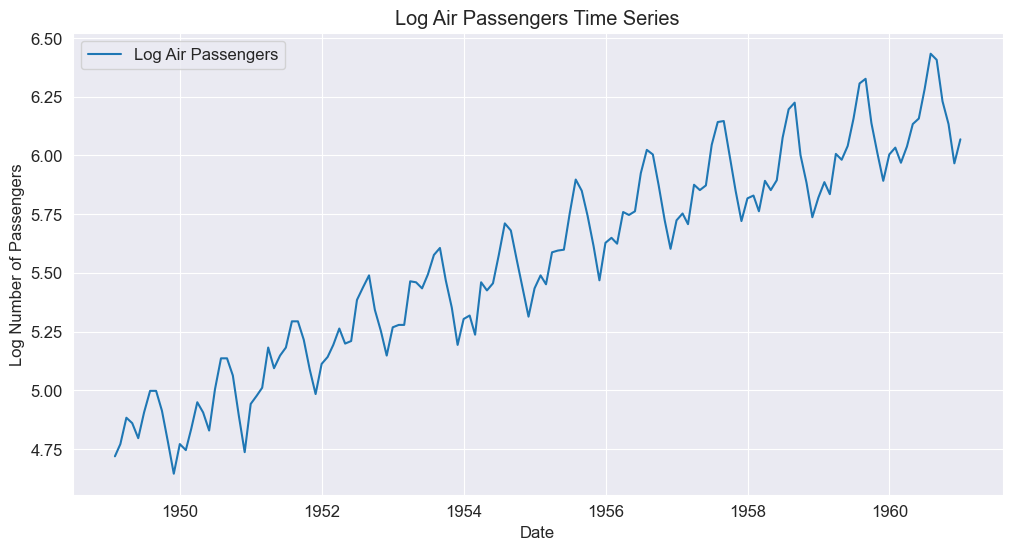

In [45]:
air_passengers_series = np.log(air_passengers_series_normal)

plt.figure(figsize=(12, 6))
plt.plot(air_passengers_series, label="Log Air Passengers")
plt.title("Log Air Passengers Time Series")
plt.xlabel("Date")
plt.ylabel("Log Number of Passengers")
plt.legend()
plt.show()

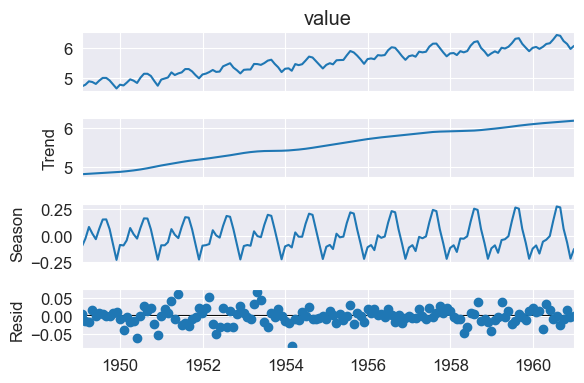

In [46]:
from statsmodels.tsa.seasonal import STL

stl = STL(air_passengers_series, seasonal=13,  period=12)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid


result.plot()
plt.show()

Are the residuals stationnary?

In [47]:
_ = is_stationary_adf_test(residual, display=True)
_ = is_stationary_kpss_test(residual, display=True)

Augmented Dickey-Fuller: Series is Stationary
KPSS test: Series is Stationary


C:\Users\Marti\AppData\Local\Temp\ipykernel_8508\1064370172.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)


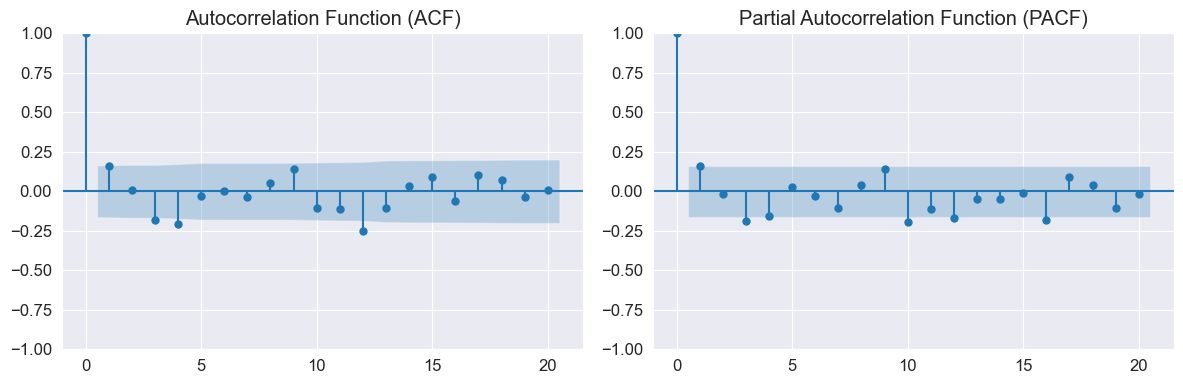

In [48]:
plot_acf_pacf(residual, lags=20, figsize=(12, 4))

I can see there is a correlation at 12 lags. This might indicate that not all seasonality has been removed.

In [49]:
order_selected = arma_order_select_ic(residual, ic='aic', trend='n', max_ar=1, max_ma=1, fit_kw={"method": "statespace"})
best_order = (order_selected.aic_min_order[0], 0, order_selected.aic_min_order[1])
print("Best order (AR):", best_order)

model = ARIMA(residual, trend='n', order=best_order)
model_fit = model.fit()
print(model_fit.summary())

Best order (AR): (1, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  144
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 346.929
Date:                Tue, 21 Jan 2025   AIC                           -689.858
Time:                        14:47:24   BIC                           -683.918
Sample:                    01-31-1949   HQIC                          -687.444
                         - 12-31-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1590      0.083      1.922      0.055      -0.003       0.321
sigma2         0.0005   4.67e-05     10.123      0.000       0.000       0.001
Ljung-Box (L1) (Q):      

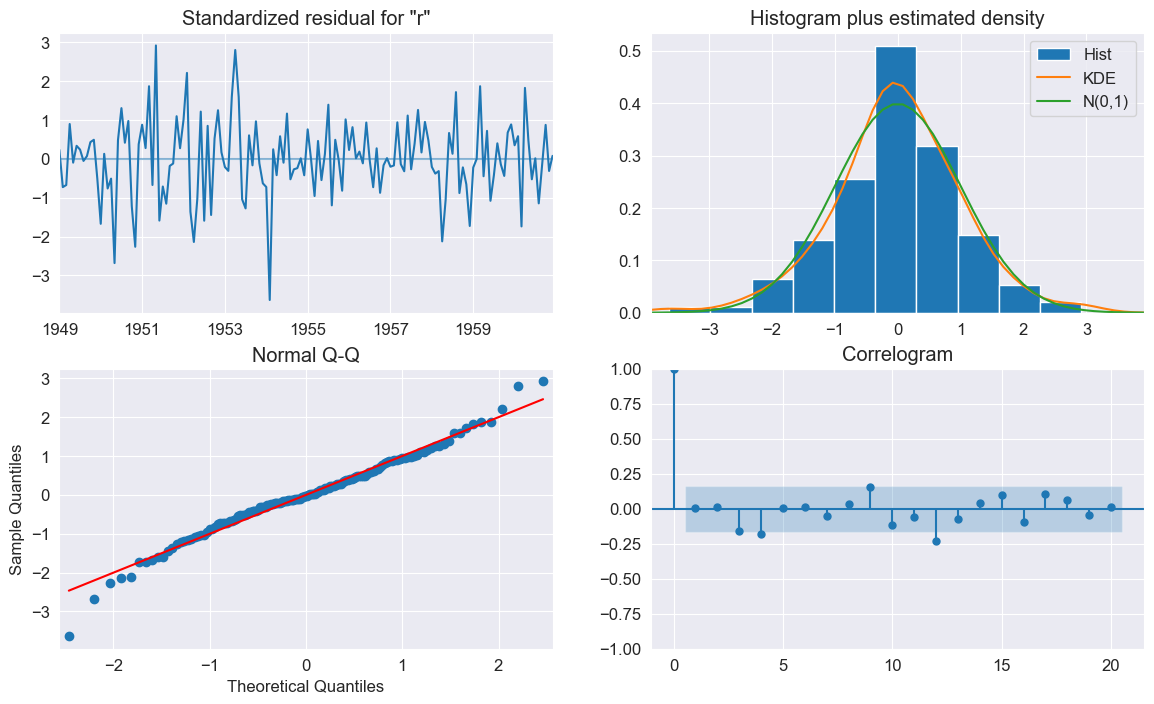

In [50]:
model_fit.plot_diagnostics(lags=20, figsize=(14, 8))
plt.show()

Se cumplen casi perfectamente las condiciones de estacionariedad para los residuos.

In [51]:
test_normality(model_fit.resid)

Shapiro-Wilk Test: Data is normally distributed
Jarque-Bera Test: Data is not normally distributed
Ljung-Box Test: No autocorrelation
ARCH Test: Constant Variance
Augmented Dickey-Fuller: Series is Stationary


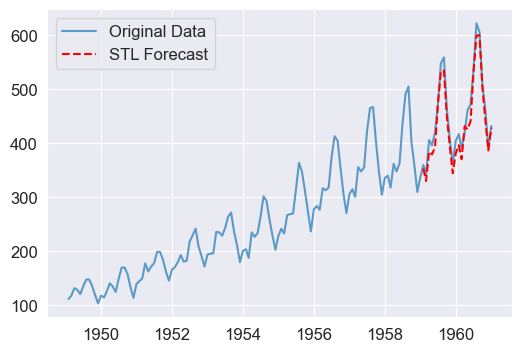

In [52]:
steps = 24
stlf = STLForecast(air_passengers_series.iloc[:-steps], ARIMA, period=12, model_kwargs={"order": (1,0,1), 'trend' : 't'}, seasonal=13)
stlf_fit = stlf.fit()
forecast = stlf_fit.forecast(steps=steps)
plt.plot(air_passengers_series_normal, label="Original Data", alpha=0.7)
plt.plot(np.exp(forecast), label="STL Forecast", color="red", linestyle="--")
plt.legend()
plt.show()

In [53]:
print("Mean absolute percentage error: ", round(
    mean_absolute_percentage_error(air_passengers_series_normal[-steps:], np.exp(forecast)),2), 
    "%")
print("Mean square error", mean_squared_error(air_passengers_series_normal[-steps:], np.exp(forecast)))

Mean absolute percentage error:  3.53 %
Mean square error 329.34608836464037


In [60]:
_ = is_stationary_adf_test(air_passengers_series, display=True)

Augmented Dickey-Fuller: Series is Non-Stationary


## SARIMA

In [63]:
sarima_model = SARIMAX(air_passengers_series, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  144
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 181.100
Date:                            Tue, 21 Jan 2025   AIC                           -354.200
Time:                                    15:22:45   BIC                           -342.669
Sample:                                01-31-1949   HQIC                          -349.515
                                     - 12-31-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4981      0.076      6.543      0.000       0.349       0.647
ar.S.L12       0.9996      0.012   

In [65]:
import pmdarima as pm 
from pmdarima.model_selection import train_test_split

In [72]:
print(len(air_passengers_series))
train, test = train_test_split(air_passengers_series, train_size=int(len(air_passengers_series) * 0.7))

model_sarima = pm.auto_arima(train, seasonal=True, m=12)
print(model_sarima.summary())

144
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 162.135
Date:                            Tue, 21 Jan 2025   AIC                           -312.271
Time:                                    15:30:30   BIC                           -297.407
Sample:                                01-31-1949   HQIC                          -306.282
                                     - 04-30-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0569      0.028      2.043      0.041       0.002       0.111
ar.L1          0.5613      0.11

Mean absolute percentage error:  11.62 %
Mean square error 3142.953341709031


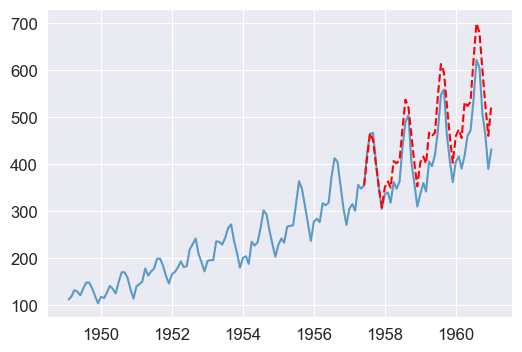

In [74]:
forecast = model_sarima.predict(test.shape[0])

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(np.exp(test), np.exp(forecast)),2), "%")
print("Mean square error", mean_squared_error(np.exp(test), np.exp(forecast)))

plt.plot(np.exp(air_passengers_series), label="Original Data", alpha=0.7)
plt.plot(np.exp(forecast), label="SARIMA Forecast", color="red", linestyle="--")

Nos ha ganado el otro modelo, pero me alegra haber podido utilzar SARIMA.

### Exponential smoothing

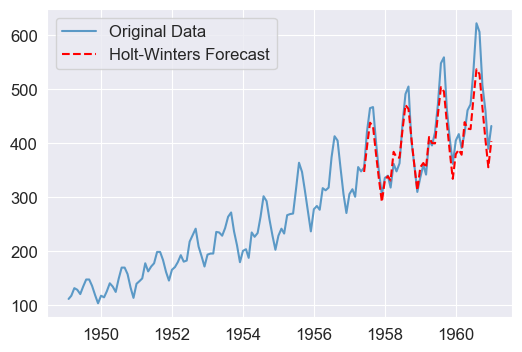

Mean absolute percentage error:  5.58 %
Mean square error 1014.92


In [82]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train, test = train_test_split(air_passengers_series_normal, train_size=int(len(air_passengers_series_normal) * 0.7))

hw_model = ExponentialSmoothing(train, trend="add", seasonal='mul', seasonal_periods=12).fit()
forecast = hw_model.forecast(test.shape[0])

plt.plot(air_passengers_series_normal, label="Original Data", alpha=0.7)
plt.plot(forecast, label="Holt-Winters Forecast", color="red", linestyle="--")
plt.legend()
plt.show()

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(test, forecast),2), "%")
print(f"Mean square error {mean_squared_error(test, forecast):.2f}")

### Mixing models

Linear regression

Mean absolute percentage error:  1.907 %
Mean square error 0.016


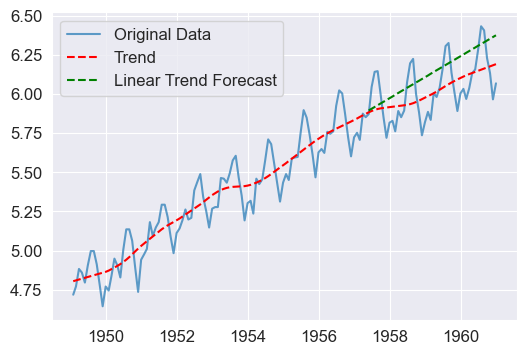

In [153]:
from sklearn.linear_model import LinearRegression
import numpy as np

train, test = train_test_split(air_passengers_series, train_size=int(len(air_passengers_series) * 0.7))

stl = STL(air_passengers_series, seasonal=13, period=12)
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

train_trend, test_trend = train_test_split(trend, train_size=int(len(air_passengers_series) * 0.7))
train_seasonal, test_seasonal = train_test_split(seasonal, train_size=int(len(air_passengers_series) * 0.7))
train_residual, test_residual = train_test_split(residual, train_size=int(len(air_passengers_series) * 0.7))

time = np.arange(len(train)).reshape(-1, 1)

lr_model = LinearRegression()
lr_model.fit(time, train_trend)

future_time = np.arange(len(train_trend), len(train_trend) + len(test_trend)).reshape(-1, 1)
future_trend_lr = lr_model.predict(future_time)

future_trend_lr = pd.Series(future_trend_lr, index=test.index)

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(test_trend, future_trend_lr),3), "%")
print(f"Mean square error {mean_squared_error(test_trend, future_trend_lr):.3f}")

plt.plot(air_passengers_series, label="Original Data", alpha=0.7)
plt.plot(trend, label="Trend", color="red", linestyle="--")
plt.plot(future_trend_lr, label="Linear Trend Forecast", color="green", linestyle="--")
plt.legend()
plt.show()

Exponential smoothing for trend

Mean absolute percentage error:  1.299 %
Mean square error 0.007


<Axes: ylabel='value'>

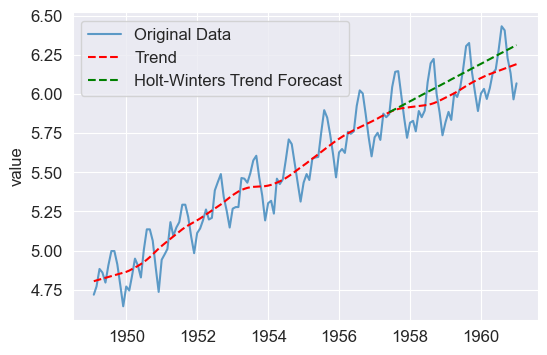

In [150]:
hw_model = ExponentialSmoothing(train_trend, trend="add").fit()
future_trend_hw = hw_model.forecast(test_trend.shape[0])

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(test_trend, future_trend_hw),3), "%")
print(f"Mean square error {mean_squared_error(test_trend, future_trend_hw):.3f}")

sns.lineplot(air_passengers_series, label="Original Data", alpha=0.7)
sns.lineplot(trend, label="Trend", color="red", linestyle="--")
sns.lineplot(future_trend_hw, label="Holt-Winters Trend Forecast", color="green", linestyle="--")

For season

Mean absolute percentage error:  78.701 %
Mean square error 0.00251


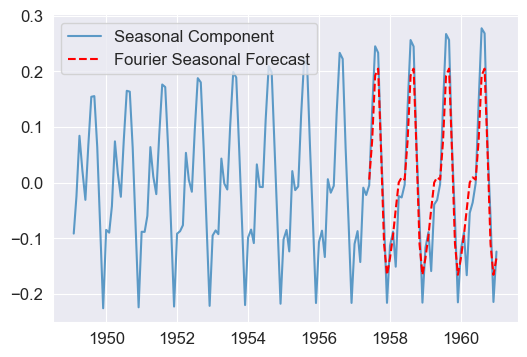

In [163]:
from statsmodels.tsa.deterministic import Fourier

fourier = Fourier(period=12, order=3) # up to 3 harmonics
seasonal_time = train_seasonal.index
fourier_terms = fourier.in_sample(seasonal_time)

seasonal_fourier_model = LinearRegression()
seasonal_fourier_model.fit(fourier_terms, train_seasonal)

future_fourier_terms = fourier.out_of_sample(steps=len(test_seasonal), index = train_seasonal.index)
future_seasonal_fourier = seasonal_fourier_model.predict(future_fourier_terms)
future_seasonal_fourier = pd.Series(future_seasonal_fourier, index=test_seasonal.index)

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(test_seasonal, future_seasonal_fourier),3), "%")
print(f"Mean square error {mean_squared_error(test_seasonal, future_seasonal_fourier):.5f}")

plt.plot(seasonal, label="Seasonal Component", alpha=0.7)
plt.plot(future_seasonal_fourier, label="Fourier Seasonal Forecast", color="red", linestyle="--")
plt.legend()
plt.show()

Using holt-winter for seasonality

Mean absolute percentage error:  37.721 %
Mean square error 0.00031


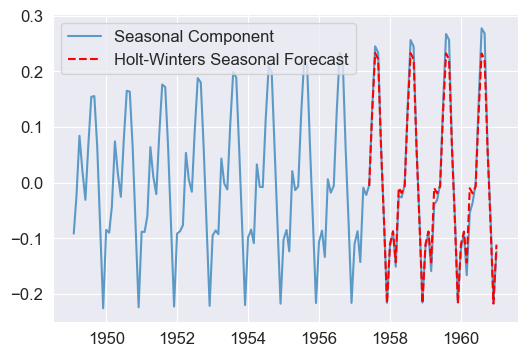

In [162]:
hw_model_seasonal = ExponentialSmoothing(train_seasonal, trend="add", seasonal='add', seasonal_periods=12).fit()
future_seasonal_hw = hw_model_seasonal.forecast(test_seasonal.shape[0])

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(test_seasonal, future_seasonal_hw),3), "%")
print(f"Mean square error {mean_squared_error(test_seasonal, future_seasonal_hw):.5f}")

plt.plot(seasonal, label="Seasonal Component", alpha=0.7)
plt.plot(future_seasonal_hw, label="Holt-Winters Seasonal Forecast", color="red", linestyle="--")
plt.legend()
plt.show()

Now the residuals. we can use ARIMA for the residuals. SARIMA or other machine learning models.

In [166]:
_ = is_stationary_adf_test(train_residual, display=True)
_ = is_stationary_kpss_test(train_residual, display=True)

Augmented Dickey-Fuller: Series is Stationary
KPSS test: Series is Stationary


C:\Users\Marti\AppData\Local\Temp\ipykernel_8508\1064370172.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)


In [170]:
import pmdarima as pm

model_arima = pm.auto_arima(train_residual, seasonal=True, m=12, max_p=2, max_q=2, max_P=2, max_Q=2)
print(model_arima.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  100
Model:             SARIMAX(0, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 248.356
Date:                                 Tue, 21 Jan 2025   AIC                           -484.712
Time:                                         16:34:16   BIC                           -469.081
Sample:                                     01-31-1949   HQIC                          -478.385
                                          - 04-30-1957                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.260      0.795      -0.002       0

Mean absolute percentage error:  110.18 %
Mean square error 0.00037


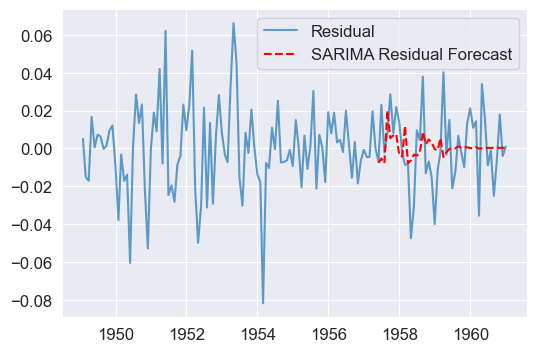

In [174]:
future_residual_sarima = model_arima.predict(test_residual.shape[0], dynamic=True)

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(test_residual, future_residual_sarima),3), "%")
print(f"Mean square error {mean_squared_error(test_residual, future_residual_sarima):.5f}")

plt.plot(residual, label="Residual", alpha=0.7)
plt.plot(future_residual_sarima, label="SARIMA Residual Forecast", color="red", linestyle="--")
plt.legend()
plt.show()

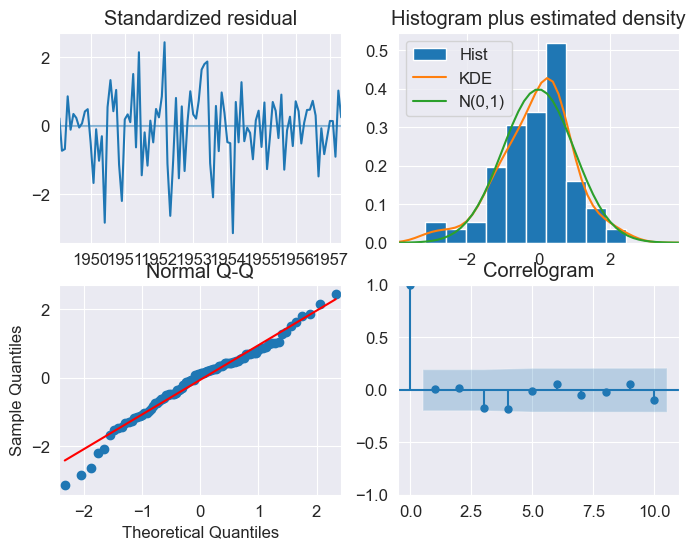

In [178]:
model_arima.plot_diagnostics(figsize=(8, 6))
plt.show()

using xgboost

C:\Users\Marti\AppData\Local\Temp\ipykernel_8508\2935262316.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_input[0, -1] = y_pred  # Add the new prediction


Mean absolute percentage error:  168.515 %
Mean square error 0.00037


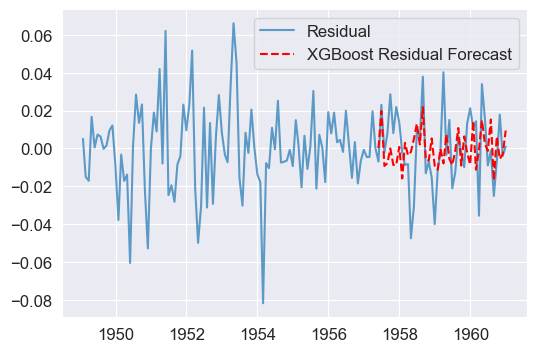

In [253]:
import xgboost as xgb

lags = 13
residuals_df = pd.concat([residual.shift(i) for i in range(1, lags+1)], axis=1)
residuals_df.columns = [f'lag_{i}' for i in range(1, lags+1)]
residuals_df.dropna(inplace=True)

X_train, X_test = residuals_df.iloc[:-len(test_residual), :], residuals_df.iloc[-len(test_residual):, :]
y_train, y_test = residual[lags:-len(test_residual)], test_residual # poner atencion a los lags de mierda

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

def recursive_forecast(model, X_init, steps):
    forecast = []
    X_input = X_init.iloc[-1].to_numpy().reshape(1,-1)  # Use the last observation
    for _ in range(steps):
        y_pred = model.predict(X_input)
        forecast.append(y_pred[0])
        # Update input with the new prediction
        X_input = np.roll(X_input, -1, axis=1)  # Shift features left
        X_input[0, -1] = y_pred  # Add the new prediction
    return np.array(forecast)

# Perform recursive forecast
residual_forecast_xbg = recursive_forecast(xgb_model, X_train, steps=len(test_residual))

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(y_test, residual_forecast_xbg),3), "%")
print(f"Mean square error {mean_squared_error(y_test, residual_forecast_xbg):.5f}")

plt.plot(residual, label="Residual", alpha=0.7)
plt.plot(test_residual.index, residual_forecast_xbg, label="XGBoost Residual Forecast", color="red", linestyle="--")
plt.legend()
plt.show()

Mean absolute percentage error:  121.043 %
Mean square error 0.00037


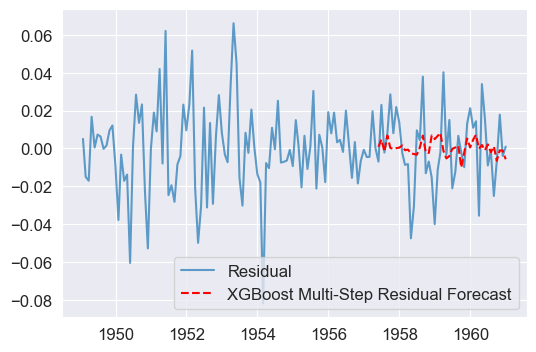

In [294]:
# Train separate models for each future step
steps = int(len(test_residual))
models = []
for step in range(steps):
    y_target = y_train.shift(-step).dropna()
    X_target = X_train.iloc[:len(y_target)]
    model = xgb.XGBRegressor( n_estimators=50, max_depth=3, 
                             learning_rate=0.01, min_child_weight=5,
                             random_state=42)
    model.fit(X_target, y_target)
    models.append(model)

# Predict each step independently
residual_forecasts_xgb_multi = [models[step].predict(X_test.iloc[-1].to_numpy().reshape(1, -1))[0] for step in range(steps)]

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(y_test, residual_forecasts_xgb_multi),3), "%")
print(f"Mean square error {mean_squared_error(y_test, residual_forecasts_xgb_multi):.5f}")

plt.plot(residual, label="Residual", alpha=0.7)
plt.plot(test_residual.index, residual_forecasts_xgb_multi, label="XGBoost Multi-Step Residual Forecast", color="red", linestyle="--")
plt.legend()
plt.show()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50}
-0.0005610776921697735
(1, 13)
Mean absolute percentage error:  96.199 %
Mean square error 0.00038


C:\Users\Marti\AppData\Local\Temp\ipykernel_8508\3663467546.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_input[0, -1] = y_pred  # Add the new prediction


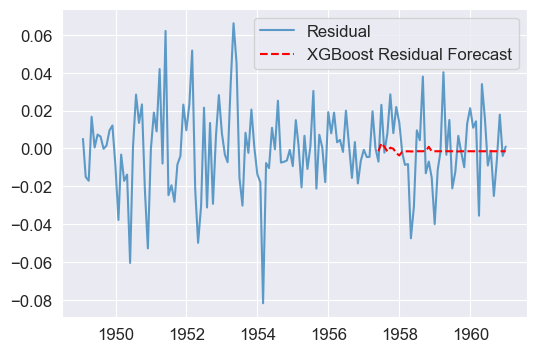

In [251]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate' : [0.01, 0.1, 0.3],
    'gamma' : [0, 0.1, 0.3],
    'min_child_weight' : [1, 3, 5],
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state = 42)

grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, n_jobs=-1, verbose=2,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

best_model = grid_search.best_estimator_

residual_forecast_xbg = recursive_forecast(best_model, X_train, steps=len(test_residual))

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(y_test, residual_forecast_xbg),3), "%")
print(f"Mean square error {mean_squared_error(y_test, residual_forecast_xbg):.5f}")

plt.plot(residual, label="Residual", alpha=0.7)
plt.plot(test_residual.index, residual_forecast_xbg, label="XGBoost Residual Forecast", color="red", linestyle="--")
plt.legend()
plt.show()

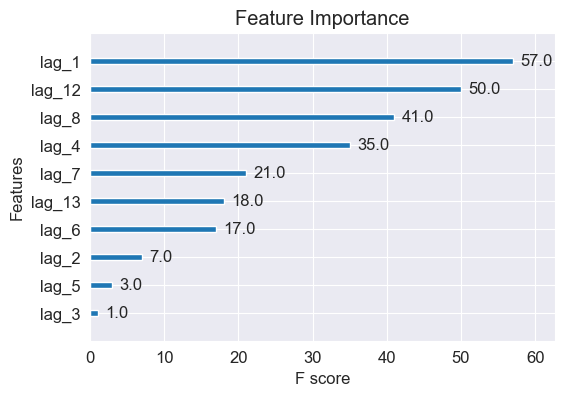

In [218]:
xgb.plot_importance(best_model)
plt.title("Feature Importance")
plt.show()


Using LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
residual_scaled = scaler.fit_transform(residual.values.reshape(-1, 1))

def create_lagged_features (data, lags):
    X, y = [], []
    for i in range(lags, len(data)):
        X.append(data[i-lags:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lags = 13
X, y = create_lagged_features(residual_scaled, lags)

X_train, X_test = X[:-len(test_residual)], X[-len(test_residual):]
y_train, y_test = y[:-len(test_residual)], y[-len(test_residual):]

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CC8C197380> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Mean absolute percentage error:  112.363 %
Mean square error 0.00041


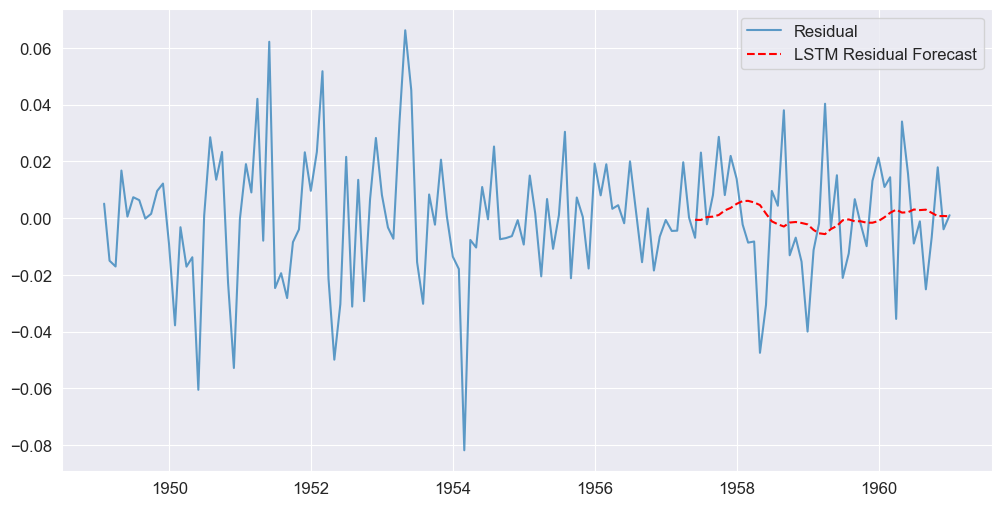

In [239]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,  # Number of epochs with no improvement
                               restore_best_weights=True)  # Restore the best model

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, 
                    epochs=50, batch_size=32, validation_data=(X_test, y_test), 
                    verbose=0, callbacks=[early_stopping])

y_pred = model.predict(X_test)

dl_pred_rescaled = scaler.inverse_transform(y_pred)
dl_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Mean absolute percentage error: ", round(mean_absolute_percentage_error(dl_test_rescaled, dl_pred_rescaled),3), "%")
print(f"Mean square error {mean_squared_error(dl_test_rescaled, dl_pred_rescaled):.5f}")

plt.figure(figsize=(12, 6))
plt.plot(residual, label="Residual", alpha=0.7)
plt.plot(test_residual.index, dl_pred_rescaled, label="LSTM Residual Forecast", color="red", linestyle="--")
plt.legend()
plt.show()

# Ojo, todos estos modelos asumen que tenemos la información anterior. Es decir, toda la informacion anterior antes del momento a calcular. 


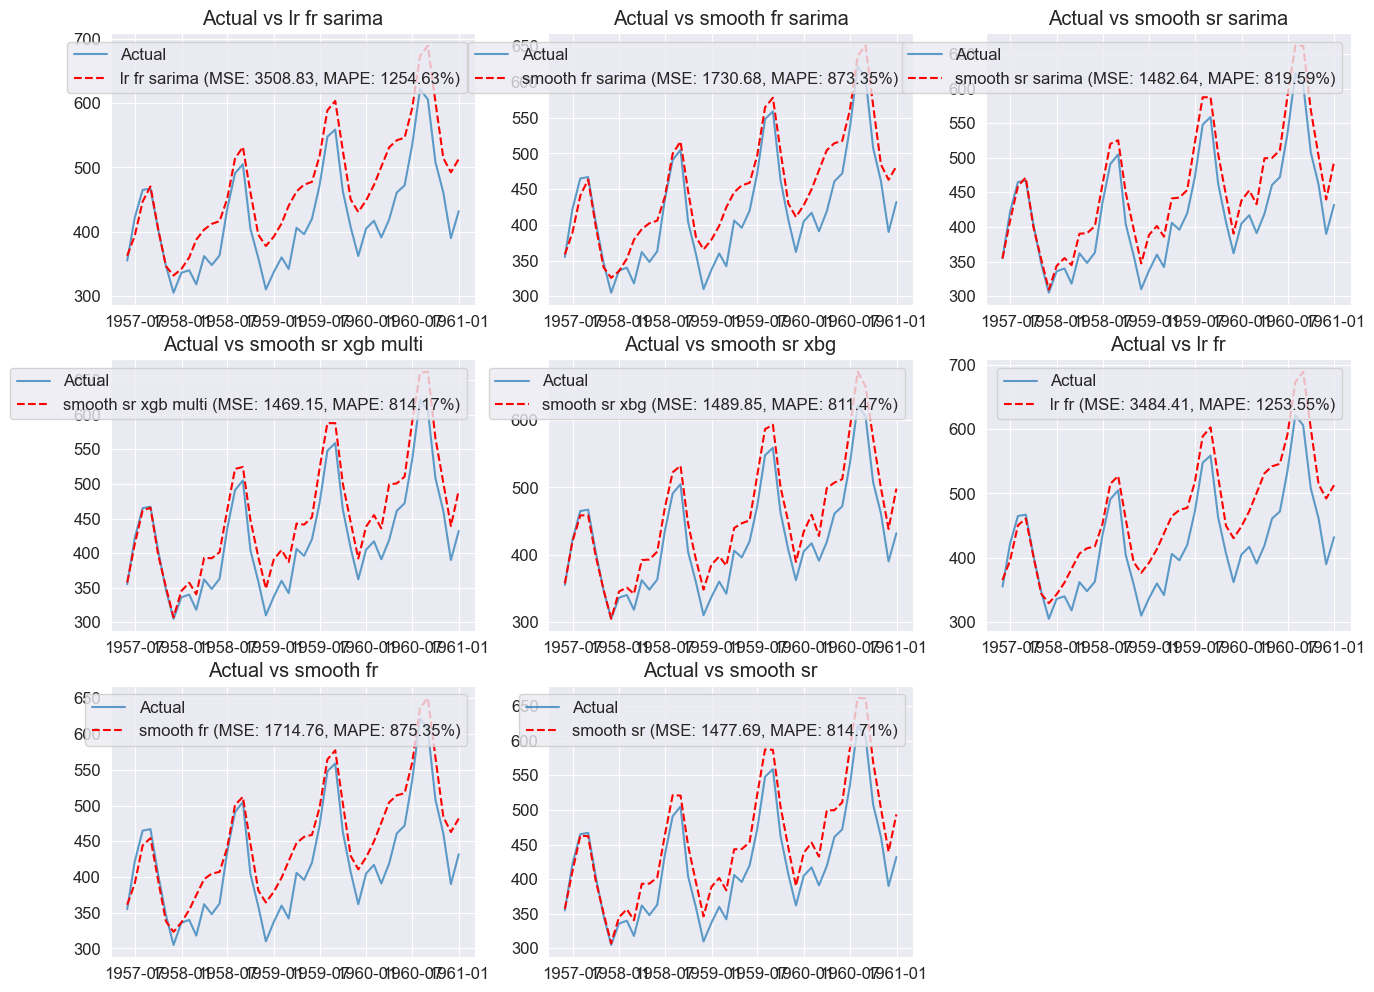

In [300]:
forecast_lr_fourier_sarima = future_trend_lr + future_seasonal_fourier + future_residual_sarima
forecast_smooth_fourier_sarima = future_trend_hw + future_seasonal_fourier + future_residual_sarima
forecast_smooth_smooth_sarima = future_trend_hw + future_seasonal_hw + future_residual_sarima
forecast_smooth_smooth_xgb_multi = future_trend_hw + future_seasonal_hw + residual_forecasts_xgb_multi
forecast_smooth_smooth_xgb = future_trend_hw + future_seasonal_hw + residual_forecast_xbg

forecast_lr_fourier = future_trend_lr + future_seasonal_fourier
forecast_smooth_fourier = future_trend_hw + future_seasonal_fourier
forecast_smooth_smooth = future_trend_hw + future_seasonal_hw


def comparator (y_true, y_pred, y_name="Actual", y_pred_name="Predicted", steps=24, 
                index_subplot = 1, index_subplot2 = 2, index_subplot3 = 3):
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    plt.subplot(index_subplot, index_subplot2, index_subplot3)
    plt.plot(y_true, label=y_name, alpha=0.7)
    plt.plot(y_pred, label=f"{y_pred_name} (MSE: {mse:.2f}, MAPE: {mape:.2%})", color="red", linestyle="--")
    plt.legend()
    plt.title(f"{y_name} vs {y_pred_name}")
    

steps = int(len(test))

index_1 = 3
index_2 = 3

plt.figure(figsize=(16, 12))
comparator(air_passengers_series_normal[-steps:], np.exp(forecast_lr_fourier_sarima), y_name="Actual", y_pred_name="lr fr sarima",
           index_subplot=index_1, index_subplot2=index_2, index_subplot3=1)
comparator(air_passengers_series_normal[-steps:], np.exp(forecast_smooth_fourier_sarima), y_name="Actual", y_pred_name="smooth fr sarima",
            index_subplot=index_1, index_subplot2=index_2,  index_subplot3=2)
comparator(air_passengers_series_normal[-steps:], np.exp(forecast_smooth_smooth_sarima), y_name="Actual", y_pred_name="smooth sr sarima",
            index_subplot=index_1, index_subplot2=index_2,  index_subplot3=3)
comparator(air_passengers_series_normal[-steps:], np.exp(forecast_smooth_smooth_xgb_multi), y_name="Actual", y_pred_name="smooth sr xgb multi",
            index_subplot=index_1, index_subplot2=index_2,  index_subplot3=4)
comparator(air_passengers_series_normal[-steps:], np.exp(forecast_smooth_smooth_xgb), y_name="Actual", y_pred_name="smooth sr xbg",
            index_subplot=index_1, index_subplot2=index_2,  index_subplot3=5)
comparator(air_passengers_series_normal[-steps:], np.exp(forecast_lr_fourier), y_name="Actual", y_pred_name="lr fr",
            index_subplot=index_1, index_subplot2=index_2,  index_subplot3=6)
comparator(air_passengers_series_normal[-steps:], np.exp(forecast_smooth_fourier), y_name="Actual", y_pred_name="smooth fr",
            index_subplot=index_1, index_subplot2=index_2,  index_subplot3=7)
comparator(air_passengers_series_normal[-steps:], np.exp(forecast_smooth_smooth), y_name="Actual", y_pred_name="smooth sr",
            index_subplot=index_1, index_subplot2=index_2,  index_subplot3=8)